c:\Users\zhant\.conda\envs\sqt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


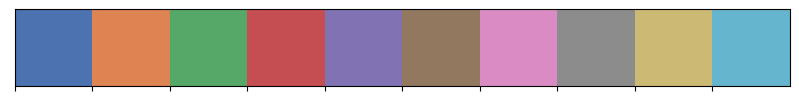

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_scatter
from tqdm import tqdm

import config_matplotlib
import seaborn as sns

cmap_global = sns.color_palette('deep')
sns.palplot(cmap_global)

In [2]:
Nb = 75
noise_level_list = [1.0, 5.0, 10.0]
pw_list = [0.1, 0.2, 0.3, 0.4]
datadir = 'benchmarks'
task_labels = ['gd', 'baseline', 'sequential', 'random']
run_labels = [f'RUN_{i+1}' for i in range(5)]

In [3]:
results = torch.load("benchmarks/summarized_results.pt")
print(results.keys())

dict_keys([(0.1, 1.0), (0.1, 5.0), (0.1, 10.0), (0.2, 1.0), (0.2, 5.0), (0.2, 10.0), (0.3, 1.0), (0.3, 5.0), (0.3, 10.0), (0.4, 1.0), (0.4, 5.0), (0.4, 10.0)])


In [4]:
fname = "benchmarks/RUN_1/bayesian_gd_pw-0.2_nl-1.0_Nb-75.pkl"

In [5]:
with open(fname, 'rb') as f:
    data_dict = pickle.load(f)

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
print("Available samples:\n", data_dict.keys())
print("Available sample information:\n", data_dict[0].keys())

Available samples:
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
Available sample information:
 dict_keys(['param_mean', 'param_std', 'param_true', 'measurement_errors', 'measurement_settings', 'measurements', 'particles', 'particle_weights'])


In [57]:
idx_sample = 7

param_true = data_dict[idx_sample]['param_true']
particles = data_dict[idx_sample]['particles']
particle_weights = data_dict[idx_sample]['particle_weights']

In [43]:
cmap = config_matplotlib.get_sequential_colormap(cmap_global[0])

In [44]:
iteration = -1
alpha = np.exp(particle_weights[iteration]) / np.exp(particle_weights[iteration]).sum()
alpha /= alpha.max()
alpha = (particle_weights[iteration] - particle_weights[iteration].min()) / (particle_weights[iteration].max() - particle_weights[iteration].min())

colors = np.concatenate([np.repeat(np.array(cmap_global[0])[None], particles.shape[-1], axis=0), alpha[:,None]], axis=1)

C:\Users\zhant\AppData\Local\Temp\ipykernel_5976\1962258962.py:4: RuntimeWarning: invalid value encountered in divide
  alpha = (particle_weights[iteration] - particle_weights[iteration].min()) / (particle_weights[iteration].max() - particle_weights[iteration].min())


In [68]:
iterations = [25, 26, 27][::-1]
for _iter in iterations:
    print(_iter)

27
26
25


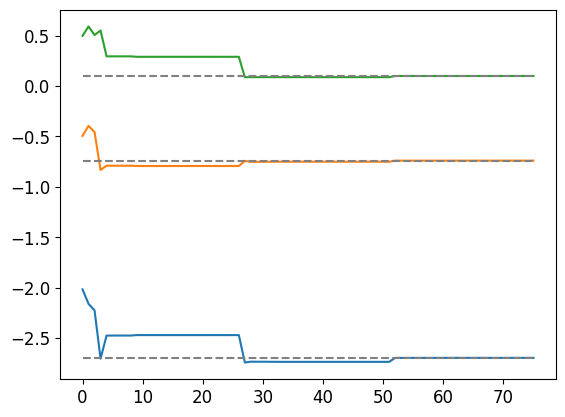

In [74]:
plt.plot(data_dict[idx_sample]['param_mean'])
plt.hlines(param_true, 0, 75, linestyles='--', colors='gray')

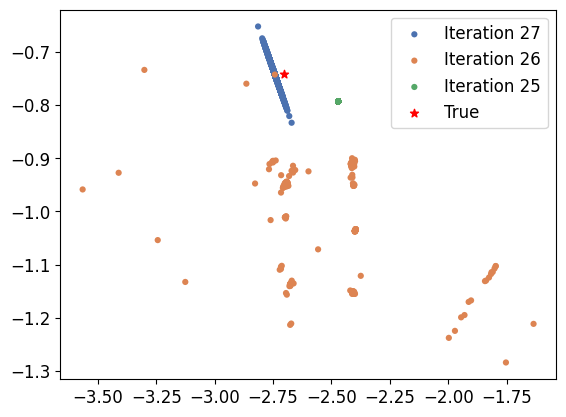

In [70]:
fig = plt.figure()
ax = fig.add_subplot()
for i, _iter in enumerate(iterations):
    # print(_iter)
    alpha = (particle_weights[_iter] - particle_weights[_iter].min()) / (particle_weights[_iter].max() - particle_weights[_iter].min() + 1e-16)
    if np.allclose(alpha, 0.):
        alpha += 0.5
    alpha /= alpha
    colors = np.concatenate([np.repeat(np.array(cmap_global[i])[None], particles.shape[-1], axis=0), alpha[:,None]], axis=1)
    # print(colors)
    ax.scatter(
        particles[_iter,0], particles[_iter,1],
        color=colors, linewidths=0, s=20, label=f"Iteration {_iter}")
ax.scatter(param_true[0], param_true[1], marker='*', c='red', label='True')
ax.legend()

25
26
27


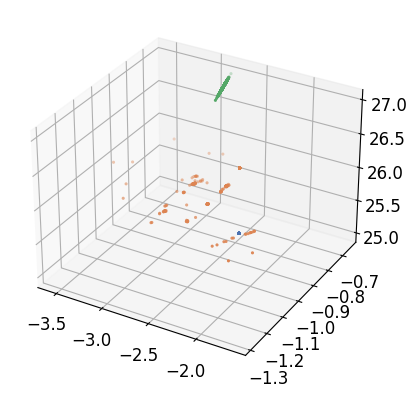

In [52]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, _iter in enumerate(iterations):
    print(_iter)
    alpha = (particle_weights[_iter] - particle_weights[_iter].min()) / (particle_weights[_iter].max() - particle_weights[_iter].min() + 1e-16)
    if np.allclose(alpha, 0.):
        alpha += 1
    colors = np.concatenate([np.repeat(np.array(cmap_global[i])[None], particles.shape[-1], axis=0), alpha[:,None]], axis=1)
    ax.scatter(
        particles[_iter,0], particles[_iter,1], _iter * np.ones_like(particles[_iter,0]),
        color=colors, linewidths=0, s=5)

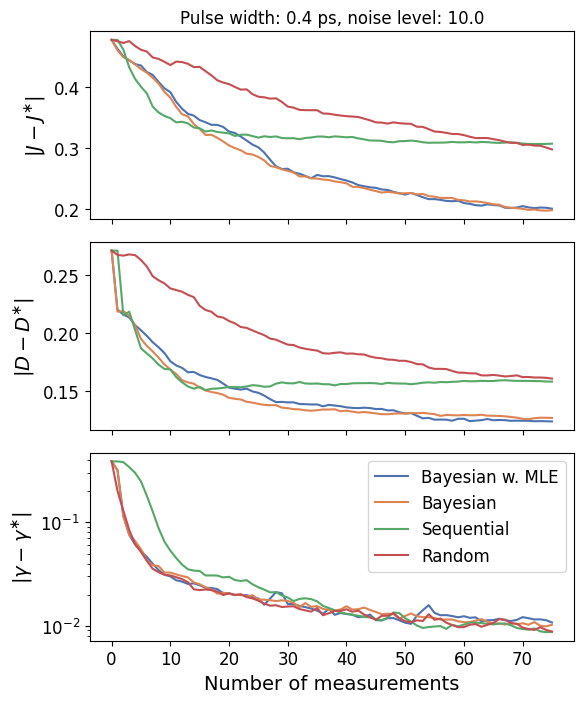

In [24]:
ylabels = ['J', 'D', '\gamma']
legends = ['Bayesian w. MLE', 'Bayesian', 'Sequential', 'Random']
fig, ax = plt.subplots(3, 1, figsize=(6,7.2), sharex=True)
for i_ax in range(3):
    for i, (_mean, _std) in enumerate(zip(loss_mean, loss_std)):
        ax[i_ax].plot(np.arange(_mean.shape[0]), _mean[...,i_ax], c=cmap_global[i], label=legends[i])
        # ax[i_ax].fill_between(np.arange(_mean.shape[0]), _mean[...,i_ax]-_std[...,i_ax], _mean[...,i_ax]+_std[...,i_ax], alpha=0.25)
    ax[i_ax].set_ylabel(rf'$|{ylabels[i_ax]}-{ylabels[i_ax]}^{{\ast}}|$')
ax[0].set_title(f"Pulse width: {pw} ps, noise level: {noise_level}")
ax[-1].set_xlabel('Number of measurements')
ax[-1].legend()
ax[-1].set_yscale('log')
fig.tight_layout()
fig.savefig(f"figures/benchmarks/pw-{pw}_nl-{noise_level}_Nb-{Nb:d}.pdf", bbox_inches='tight')

IndexError: list index out of range

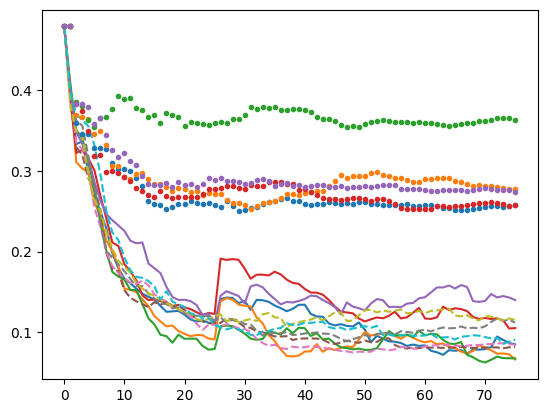

In [85]:
idx = 0
linestyles = ['-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '.', '.', '.', '.', '.']
# linestyles = ['-', '-', '--', '--', '.', '.']
fig, ax = plt.subplots(1, 1)
for i, _loss in enumerate(loss_info_lst):
    ax.plot(np.arange(_loss.shape[1]), _loss.mean(axis=0)[:,idx], linestyles[i])
    # ax.fill_between(np.arange(loss.shape[1]), 
    #     loss.mean(axis=0)[:,idx]-0.05*loss.std(axis=0)[:,idx],
    #     loss.mean(axis=0)[:,idx]+0.05*loss.std(axis=0)[:,idx], alpha=0.25)

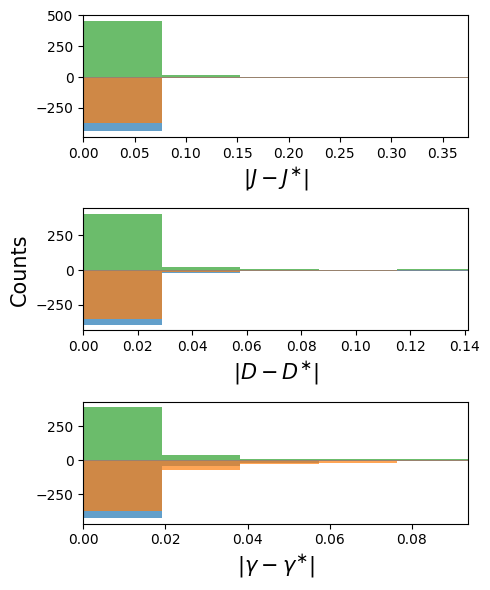

In [22]:
i_iter = -1

xlabels = ['J', 'D', '\gamma']

fig, ax = plt.subplots(3, 1, figsize=(5,6))
for i_ax in range(3):
    bins = np.linspace(0, loss[...,i_ax].max(), 50)
    for i_param in range(3):
        data = torch.cat(torch.unbind(loss[index==i_param], dim=0)).numpy()
        counts, bins = np.histogram(data[:,i_iter,i_ax], bins=bins)
        if i_param == 2:
            ax[i_ax].bar((bins[:-1]+bins[1:])/2, counts, width=bins[1]-bins[0], alpha=0.7)
        else:
            ax[i_ax].bar((bins[:-1]+bins[1:])/2, -counts, width=bins[1]-bins[0], alpha=0.7)
        # ax[i_ax].set_yscale('log')
    ax[i_ax].hlines(0, -10, 10, colors='gray', linestyles='-', linewidth=0.5)
    ax[i_ax].set_xlabel(rf'$|{xlabels[i_ax]}-{xlabels[i_ax]}^{{\ast}}|$', fontsize=15)
    ax[i_ax].set_xlim([0, 0.1 * loss[...,i_ax].max()])
    # ax[i_ax].set_yticks([-300,  0, 300])
    if i_ax == 1:
        ax[i_ax].set_ylabel('Counts', fontsize=15)
    # ax[i_ax].set_yticklabels(['-500', '0', '500'])
fig.tight_layout()
# fig.savefig(f"figs/paper/comparisons/hist_pw-{pw}_nl-{noise_level}_Nb-200.pdf", bbox_inches='tight')

(-1.0, 3.0)

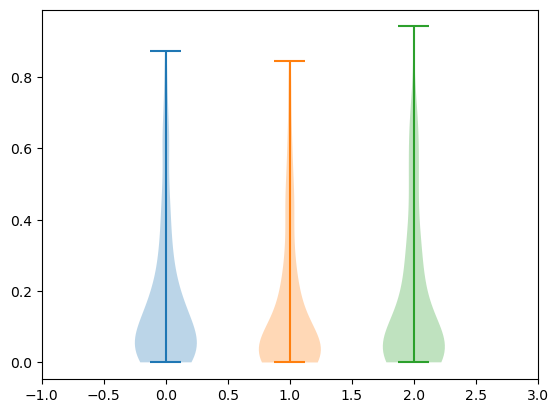

In [6]:
import seaborn as sns

idx = 1
iter_num = 10

fig = plt.figure()
ax = fig.add_subplot()
ax.violinplot(loss_info_lst[0][:,iter_num,idx], positions=[0])
ax.violinplot(loss_info_lst[4][:,iter_num,idx], positions=[1])
ax.violinplot(loss_info_lst[-1][:,iter_num,idx], positions=[2])
# sns.swarmplot(x=0*np.ones_like(loss_info_lst[0][:,iter_num,idx]), y=loss_info_lst[0][:,iter_num,idx], orient='v')
# sns.swarmplot(x=1*np.ones_like(loss_info_lst[4][:,iter_num,idx]), y=loss_info_lst[4][:,iter_num,idx], orient='v')
# sns.swarmplot(x=2*np.ones_like(loss_info_lst[-1][:,iter_num,idx]), y=loss_info_lst[-1][:,iter_num,idx], orient='v')
ax.set_xlim([-1, 3])
# ax.set_yscale('log')

In [7]:
with open('{datadir}/bayesian_baseline_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    baseline_dict = pickle.load(f)
# with open('{datadir}/bayesian_baseline_pw-0.1_nl-10.0_Nb-200.pkl', 'rb') as f:
#     baseline_dict_nl10 = pickle.load(f)
with open('{datadir}/bayesian_random_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    random_dict = pickle.load(f)
with open('{datadir}/bayesian_gradientdesc_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    gd_dict = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/benchmark/bayesian_baseline_pw-0.1_nl-5.0_Nb-200.pkl'

In [ ]:
l1_diff_baseline = np.abs(baseline_dict['param_mean'] - baseline_dict['param_true'][:,None,:])
# l1_diff_baseline_nl10 = np.abs(baseline_dict_nl10['param_mean'] - baseline_dict_nl10['param_true'][:,None,:])
l1_diff_random = np.abs(random_dict['param_mean'] - random_dict['param_true'][:,None,:])
l1_diff_gd = np.abs(gd_dict['param_mean'] - gd_dict['param_true'][:,None,:])

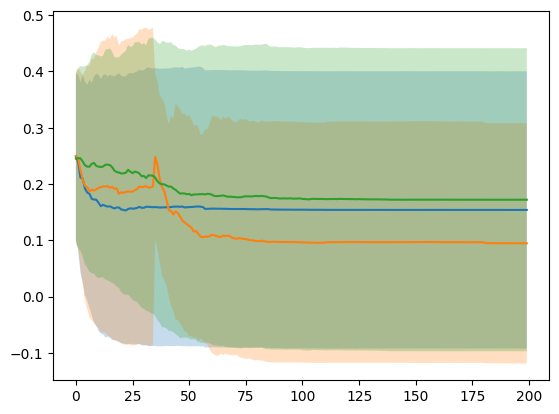

In [ ]:
idx = 1

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(l1_diff_baseline.shape[1]), l1_diff_baseline.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_baseline.shape[1]), 
    l1_diff_baseline.mean(axis=0)[:,idx]-l1_diff_baseline.std(axis=0)[:,idx],
    l1_diff_baseline.mean(axis=0)[:,idx]+l1_diff_baseline.std(axis=0)[:,idx], alpha=0.25)

# ax.plot(np.arange(l1_diff_baseline_nl10.shape[1]), l1_diff_baseline_nl10.mean(axis=0)[:,idx])
# ax.fill_between(np.arange(l1_diff_baseline_nl10.shape[1]), 
#     l1_diff_baseline_nl10.mean(axis=0)[:,idx]-l1_diff_baseline_nl10.std(axis=0)[:,idx],
#     l1_diff_baseline_nl10.mean(axis=0)[:,idx]+l1_diff_baseline_nl10.std(axis=0)[:,idx], alpha=0.25)

ax.plot(np.arange(l1_diff_gd.shape[1]), l1_diff_gd.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_gd.shape[1]), 
    l1_diff_gd.mean(axis=0)[:,idx]-l1_diff_gd.std(axis=0)[:,idx],
    l1_diff_gd.mean(axis=0)[:,idx]+l1_diff_gd.std(axis=0)[:,idx], alpha=0.25)

ax.plot(np.arange(l1_diff_random.shape[1]), l1_diff_random.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_random.shape[1]), 
    l1_diff_random.mean(axis=0)[:,idx]-l1_diff_random.std(axis=0)[:,idx],
    l1_diff_random.mean(axis=0)[:,idx]+l1_diff_random.std(axis=0)[:,idx], alpha=0.25)